# Try different ways of plotting the data.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

### Load data.

In [2]:
# File
previous, current = os.path.split(os.getcwd())
dname = previous[0:-5]

fname = dname + '\\data\\GLMM\\data_sentences_pk_env.pkl'

# Dump information to that file
df = pickle.load(open(fname, 'rb'))

In [3]:
# Get dimensions
n_sujs, n_trials, n_vitesses = df['score'].shape
print(n_sujs, n_trials, n_vitesses)

21 100 7


### Binning parameters.

In [4]:
# Binning parameters
n_bins = 5
prop = 0.33
n_bins_syll = 10
prop_syll = 0.1

### Binning function.

In [5]:
def binVector(X, n_bins=5, prop=None):
    "Return indexes to bin continuous values"
    import numpy as np
    X = np.array(X)
    
    # Get overlapping proportion or not
    if prop is None:
        prop = 1./n_bins
    
    # Declare indexes
    shape = list(X.shape)
    shape.append(n_bins)
    shape = np.roll(shape, 1) # First dimensions is n_bins
    idx = np.zeros(shape, dtype=np.bool_)
    
    # Get boundaries
    lower_quantiles = np.quantile(X, np.linspace(0, (1-prop), n_bins))
    upper_quantiles = np.quantile(X, np.linspace(prop, 1, n_bins))
    
    # Fill indexes
    for i in range(n_bins): # for loop is ok here
        idx[i] = np.logical_and(X > lower_quantiles[i], X < upper_quantiles[i])
    return idx

### Plot Figure Supp. 5.

In [6]:
var_names = [
    'syll_rate',
    'peak_env',
    'phon_rate',
    'phir_rate',
    'syir_rate',
    'stat_surp', 
    'ctxt_surp'
]
titles = [
    r'Syllabic rate',
    'Acoustic\n modulation rate',
    r'Phonemic rate',
    r'Phonemic information',
    r'Syllabic information',
    'Static lexical\n surprise',
    'Contextual lexical\n surprise'
]
xlabels = [
    r'rate ($s^{-1}$)',
    r'rate ($s^{-1}$)',
    r'rate ($s^{-1}$)',
    r'surprise rate ($bit.s^{-1}$)',
    r'surprise rate ($bit.s^{-1}$)',
    r'surprise rate ($bit.s^{-1}$)',
    r'surprise rate ($bit.s^{-1}$)'
]
cmaps = [get_cmap('Oranges'),get_cmap('Greys'),get_cmap('RdPu'),  get_cmap('YlOrBr'), 
        get_cmap('Greens'), get_cmap('Blues') , get_cmap('Purples')]

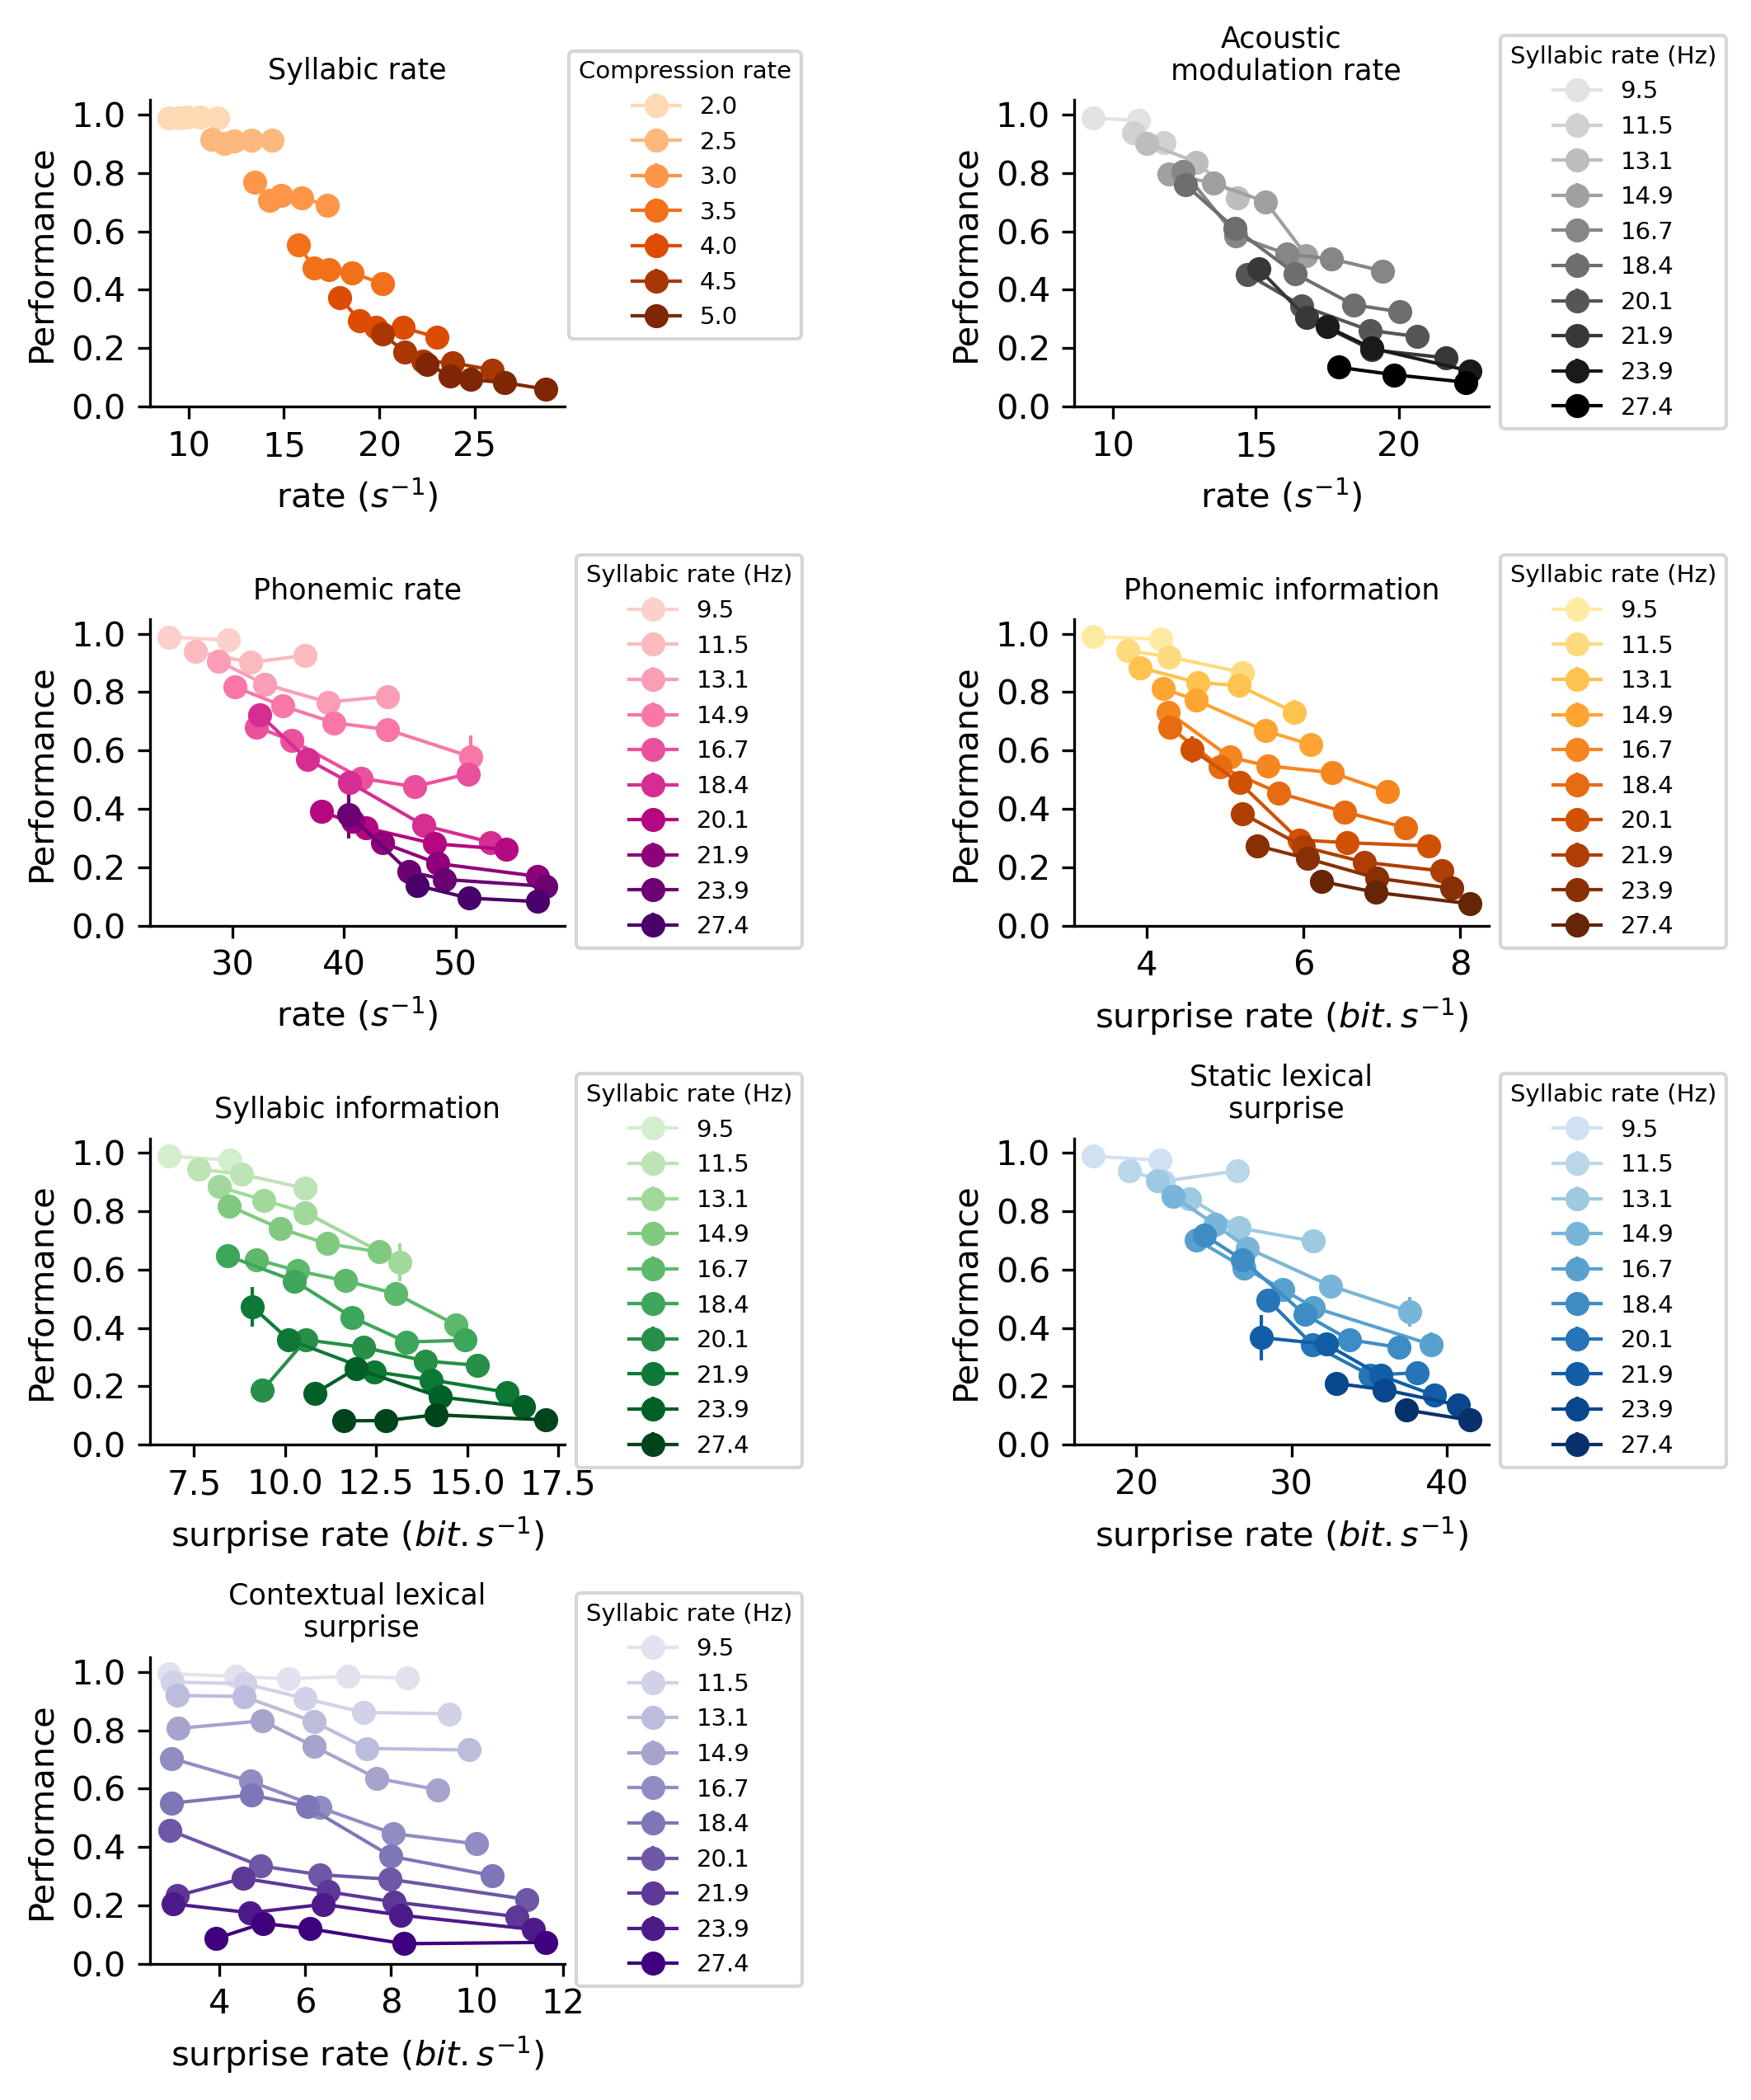

In [7]:
# Declare figure
fig, axs = plt.subplots(4, 2, figsize=(7.09,8.5), facecolor='w', dpi=300)
plt.rcParams["font.size"] = "7"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    # Loop across variables
    for i, (ax, var_name, title, xlabel, cmap) in enumerate(zip(
        axs.ravel(), var_names, titles, xlabels, cmaps)):

        # Get x-axis data
        X = df[var_names[i]] / df['vitesse'][0, 0, :]

        # Get syllabic rate bins dependent of compression
        idx_syll_compressed = binVector(df['syll_rate'], n_bins=n_bins_syll, prop=prop_syll)

        # Plot 
        # Two cases : syllabic rate and the other ones
        if i == 0:

            # Get variable bins
            idx = binVector(X, n_bins=n_bins, prop=prop)

            for j in np.arange(n_vitesses):

                # Declare grand average
                M = np.zeros(n_bins)
                SE = np.zeros(n_bins)    
                X_values = np.zeros(n_bins)

                # Loop in binning of (not compressed) syllabic rate
                for k in np.arange(n_bins):
                    m_suj = np.mean(df['score'][:, idx[k, 0, :, j], j], axis=-1)
                    X_values[k] = np.mean(X[0, idx[k, 0, :, j], j] * df['vitesse'][0, 0, j])
                    M[k] = np.mean(m_suj)
                    SE[k] = np.std(m_suj) / np.sqrt(n_sujs)

                # Define color
                color = cmap(np.linspace(0.2, 1, n_vitesses)[j])

                # Plot lines
                ax.errorbar(X_values, M, yerr=SE, marker='o', color=color, linewidth=1, 
                           label=df['vitesse'][0, 0, j])

                # Aesthetics
                ax.set_xlabel(xlabel)
                ax.set_ylabel('Performance')
                ax.set_title(title)
                ax.set_ylim(0, 1.05)
                ax.spines["right"].set_visible(False)
                ax.spines["top"].set_visible(False)

                # Legend
                im = ax.legend(bbox_to_anchor=(1.6,1.2))#, loc="upper left"loc=1)
                im.set_title('Compression rate')

        # Two cases : syllabic rate and the other ones
        else:

            # Get variable bins
            idx = binVector(df[var_names[i]], n_bins=n_bins, prop=prop)

            # Loop in binning of (compressed) syllabic rate
            for j in np.arange(n_bins_syll):

                # Declare grand average
                M = np.zeros(n_bins)
                SE = np.zeros(n_bins)    
                X_values = np.zeros(n_bins)

                for k in np.arange(n_bins):
                    # df['score'].shape is n_sujs, n_trials, n_vitesses
                    # Here we choose trials and vitesses that correspond to 
                    # the good "syll_rate" (compressed) binning and 
                    # the good (uncompressed) "phon_rate" binning (for example)
                    total_idx = idx[k, 0] * idx_syll_compressed[j, 0]
                    m_suj = np.mean(df['score'][:, total_idx], axis=-1)
                    X_values[k] = np.mean(df[var_names[i]][0, total_idx])
                    M[k] = np.mean(m_suj)
                    SE[k] = np.std(m_suj) / np.sqrt(n_sujs)

                # Define color
                color = cmap(np.linspace(0.2, 1, n_bins_syll)[j])

                # Plot lines
                ax.errorbar(X_values, M, yerr=SE, marker='o', color=color, linewidth=1, 
                           label=np.around(np.mean(df['syll_rate'][0, idx_syll_compressed[j, 0]], axis=-1), 1))

                # Aesthetics
                ax.set_xlabel(xlabel)
                ax.set_ylabel('Performance')
                ax.set_title(title)
                ax.set_ylim(0, 1.05)
                ax.spines["right"].set_visible(False)
                ax.spines["top"].set_visible(False)

                # Legend
                im = ax.legend(bbox_to_anchor=(1.,1.25))#, loc="upper left"loc=1)
                im.set_title('Syllabic rate (Hz)')
axs.ravel()[7].set_axis_off()
plt.tight_layout();

In [9]:
#fig.savefig(dname + '/Figures/Figure_Supp_5.png', dpi=300, bbox_inches='tight')